<class 'pandas.core.frame.DataFrame'>
RangeIndex: 350 entries, 0 to 349
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  350 non-null    int64 
 1   review      350 non-null    object
 2   starRating  350 non-null    int64 
 3   label       350 non-null    int64 
dtypes: int64(3), object(1)
memory usage: 11.1+ KB
None
Fitting 3 folds for each of 1176 candidates, totalling 3528 fits
{'C': 0.001, 'degree': 1, 'gamma': 1000, 'kernel': 'rbf'} 0.8257
정확도 :  0.8
감성 분석할 문장입력 : 서비스
['서비스']
['서비스'] : 부정 감성


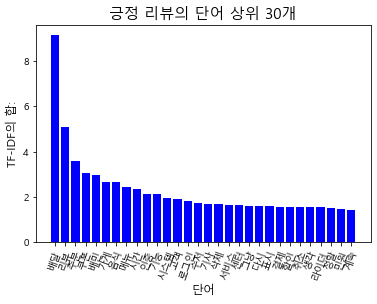

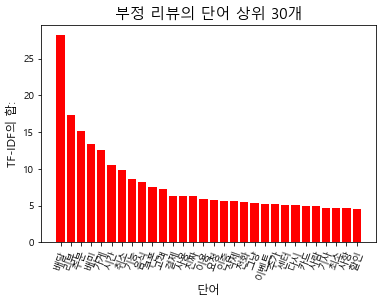

[(0, '0.029*"배달" + 0.022*"주문" + 0.021*"리뷰" + 0.018*"배민" + 0.017*"가게" + 0.015*"취소" + 0.009*"인증" + 0.009*"시간" + 0.006*"음식" + 0.006*"요청" + 0.006*"쿠폰" + 0.006*"그냥" + 0.006*"고객" + 0.005*"결제" + 0.005*"사람"'), (1, '0.068*"배달" + 0.019*"리뷰" + 0.015*"배민" + 0.013*"시간" + 0.012*"가게" + 0.011*"음식" + 0.011*"주문" + 0.010*"고객" + 0.010*"쿠폰" + 0.009*"기사" + 0.007*"기능" + 0.007*"사용" + 0.006*"결제" + 0.006*"그냥" + 0.006*"요청"'), (2, '0.036*"배달" + 0.025*"리뷰" + 0.023*"배민" + 0.014*"시간" + 0.012*"주문" + 0.012*"가게" + 0.010*"음식" + 0.009*"쿠폰" + 0.008*"취소" + 0.008*"삭제" + 0.007*"고객" + 0.007*"인증" + 0.006*"이용" + 0.005*"기능" + 0.005*"사람"'), (3, '0.038*"배달" + 0.029*"주문" + 0.027*"리뷰" + 0.020*"가게" + 0.017*"배민" + 0.011*"고객" + 0.011*"취소" + 0.009*"음식" + 0.009*"쿠폰" + 0.008*"시간" + 0.008*"센터" + 0.007*"기능" + 0.007*"그냥" + 0.006*"메뉴" + 0.006*"전화"')]


In [2]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import pandas as pd
import time
import gensim
import gensim.corpora as corpora
import pyLDAvis.gensim_models
import warnings
import re
import random
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from bs4 import BeautifulSoup
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from konlpy.tag import Okt
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

warnings.filterwarnings(action='ignore')

def crawlReview(driver,data,k,quotient,remainder):    
    reviews = driver.find_elements_by_css_selector('.UD7Dzf')
    star_grades = driver.find_elements_by_xpath('//div[@class="pf5lIe"]/div[@role="img"]')    
    base=200+quotient*160
    print(quotient)
    if len(reviews)<k:
            reviewCount=len(reviews)
    else:        
        if k<=200:            
                reviewCount=k
        else:                        
                reviewCount=base+remainder
    print("리뷰 개수 : "+str(reviewCount))
    for i in range(reviewCount):
        tmp = []        
        tmp.append(reviews[i].text)
        starText=star_grades[i].get_attribute('aria-label')
        tmp.append(starText[10])
        label=0
        if int(starText[10])==2 or int(starText[10])==1:
            label=0
        elif int(starText[10])==4 or int(starText[10])==5:
            label=1
        tmp.append(label)
        tmp = pd.DataFrame(data=[tmp], columns=data.columns)
        data = pd.concat([data,tmp])
    
    print("앱 리뷰 수집 완료")
    return data
    
def crawlReviews(driver,data,k):
    result=scrolling(driver,data,k)
    return result

class elementWithCssClass(object):            
    def __call__(self, driver):               
        driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")
        element=driver.find_element_by_css_selector('div#fcxH9b > div.WpDbMd > c-wiz > div > div.ZfcPIb > div > div > main > div > div.W4P4ne  > div:nth-of-type(2) > div.PFAhAf')
        if 'PFAhAf' in element.get_attribute("class"):        
            return element
        else:
            return False

def scrolling(driver,data,k):
    try:                
        reviews = driver.find_elements_by_css_selector('.UD7Dzf')
        remainder=0
        if k<=200: # 기본적으로 리뷰 200개 화면에 제공
            count=0
            quotient=0
        else:
            remainder=(k-200)%160   
            if remainder==0:
                count=(k-200)//160
            else:
                count=(k-200)//160 + 1 #리뷰 더보기를 클릭하면 추가적으로 160개 화면에 추가제공                     
            quotient=count-1     
        print(count)
        i=0                
        pause_time=2        
        while True:       
            driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")
            time.sleep(pause_time)                                                
            value=elementWithCssClass()            
            element = WebDriverWait(driver, 20).until(value)            
            if value != False:
                if count !=i:                    
                    element.click();            
                    i+=1
                else:
                    break                                   
        result=crawlReview(driver,data,k,quotient,remainder)
        return result
    except Exception as e:
        print("error occurred: ", e)

def okt_tokenizer(text):
    tokens=okt.morphs(text)
    return tokens

pd.set_option('display.max_rows',100)
data=pd.DataFrame(data=[],columns=['review','starRating','label'])
wd = webdriver.Chrome("chromedriver.exe")
url = 'https://play.google.com/store/apps/details?id=com.sampleapp&hl=ko&gl=US&showAllReviews=true'
wd.get(url)

#배너가 더보기 버튼을 가리므로 배너 삭제
wd.execute_script(""" 
   var l = document.getElementsByClassName("t5eBue ovVTif")[0];
   l.parentNode.removeChild(l);
""")

result=crawlReviews(wd,data,500)
result.reset_index(inplace=True, drop=True)
result.index.name='id'
result['review']=result['review'].apply(lambda x: re.sub(r'[^ ㄱ-ㅣ가-힣]+', " ",x))
print(result.info())

result_train=result.sample(frac=0.7,random_state=150)
result_test=result.drop(result_train.index)
result_train.reset_index(inplace=True, drop=True)
result_test.reset_index(inplace=True, drop=True)

result_train.to_csv('./AppReview_train.csv',encoding="utf-8-sig",mode='w')
result_test.to_csv('./AppReview_test.csv',encoding="utf-8-sig",mode='w')

read_train_data=pd.read_csv('./AppReview_train.csv')
read_test_data=pd.read_csv('./AppReview_test.csv')
read_train_data.index.name='id'
read_test_data.index.name='id'
print(read_train_data.info())
okt=Okt()
tfidf=TfidfVectorizer(tokenizer=okt_tokenizer,ngram_range=(1,2),min_df=3,max_df=0.9)
tfidf.fit(read_train_data['review'])
train_tfidf=tfidf.transform(read_train_data['review'])
SA_lr=LogisticRegression(random_state=0)
SA_lr.fit(train_tfidf,read_train_data['label'])
model=SVC()
param_grid = { 'C':[0.001,0.01,0.1,1,10,100,1000],'kernel':['rbf','poly','sigmoid','linear'],'degree':[1,2,3,4,5,6],'gamma': [1000,100,10,1, 0.1, 0.01, 0.001]}
grid = GridSearchCV(model,param_grid,cv=3,scoring='accuracy',verbose=1)
grid.fit(train_tfidf,read_train_data['label'])
print(grid.best_params_,round(grid.best_score_,4))
SA_lr_best=grid.best_estimator_
test_tfidf=tfidf.transform(read_test_data['review'])
test_predict=SA_lr_best.predict(test_tfidf)

print('정확도 : ',round(accuracy_score(read_test_data['label'],test_predict),3))

st=input("감성 분석할 문장입력 : ")
st=re.compile(r'[ㄱ-ㅣ가-힣]+').findall(st)
print(st)
st=[" ".join(st)]
st_tfidf=tfidf.transform(st)
st_predict=SA_lr_best.predict(st_tfidf)
if(st_predict==0):
    print(st, ": 부정 감성")
else:
    print(st, ": 긍정 감성")
    
columns_name=['review','label']
NEG_data_df=pd.DataFrame(columns=columns_name)
POS_data_df=pd.DataFrame(columns=columns_name)

for i, data in read_train_data.iterrows():
    review=data['review']
    label=data['label']
    if label==0:
       NEG_data_df=NEG_data_df.append(pd.DataFrame([[review,label]],columns=columns_name),ignore_index=True)
    else:                        
       POS_data_df=POS_data_df.append(pd.DataFrame([[review,label]],columns=columns_name),ignore_index=True)
                                  
POS_data_df.to_csv('./POS_review.csv',encoding='euc-kr')
NEG_data_df.to_csv('./NEG_review.csv',encoding='euc-kr')

POS_review=POS_data_df['review']
POS_review_noun_tk=[]
for d in POS_review:
    POS_review_noun_tk.append(okt.nouns(d))
POS_review_noun_join=[]
for d in POS_review_noun_tk:
    d2=[w for w in d if len(w) > 1]
    POS_review_noun_join.append(" ".join(d2))

POS_tfidf=TfidfVectorizer(tokenizer=okt_tokenizer,min_df=2)
POS_dtm=POS_tfidf.fit_transform(POS_review_noun_join)
POS_vocab=dict()
for idx, word in enumerate(POS_tfidf.get_feature_names()):
    POS_vocab[word]=POS_dtm.getcol(idx).sum()
POS_words=sorted(POS_vocab.items(),key=lambda x:x[1],reverse=True)

NEG_review=NEG_data_df['review']
NEG_review_noun_tk=[]
for d in NEG_review:
    NEG_review_noun_tk.append(okt.nouns(d))
NEG_review_noun_join=[]
for d in NEG_review_noun_tk:
    d2=[w for w in d if len(w) > 1]
    NEG_review_noun_join.append(" ".join(d2))

NEG_tfidf=TfidfVectorizer(tokenizer=okt_tokenizer,min_df=2)
NEG_dtm=NEG_tfidf.fit_transform(NEG_review_noun_join)
NEG_vocab=dict()
for idx, word in enumerate(NEG_tfidf.get_feature_names()):
    NEG_vocab[word]=NEG_dtm.getcol(idx).sum()
NEG_words=sorted(NEG_vocab.items(),key=lambda x:x[1],reverse=True)

fm.get_fontconfig_fonts()
font_location='C:/Windows/Fonts/malgun.ttf'
font_name=fm.FontProperties(fname=font_location).get_name()
matplotlib.rc('font',family=font_name)
max=30

plt.bar(range(max),[i[1] for i in POS_words[:max]],color="blue")
plt.title("긍정 리뷰의 단어 상위 %d개" %max,fontsize=15)
plt.xlabel("단어",fontsize=12)
plt.ylabel("TF-IDF의 합:",fontsize=12)
plt.xticks(range(max),[i[0] for i in POS_words[:max]],rotation=70)
plt.show()

plt.bar(range(max),[i[1] for i in NEG_words[:max]],color="red")
plt.title("부정 리뷰의 단어 상위 %d개" %max,fontsize=15)
plt.xlabel("단어",fontsize=12)
plt.ylabel("TF-IDF의 합:",fontsize=12)
plt.xticks(range(max),[i[0] for i in NEG_words[:max]],rotation=70)
plt.show()
review=read_train_data['review']
review_noun_tk=[]
for d in review:
    review_noun_tk.append(okt.nouns(d))
review_noun_tk2=[]
for d in review_noun_tk:
    item=[i for i in d if len(i)>1]
    review_noun_tk2.append(item)
dictionary=corpora.Dictionary(review_noun_tk2)
corpus=[dictionary.doc2bow(word) for word in review_noun_tk2]
k=4
lda_model=gensim.models.ldamulticore.LdaMulticore(corpus,iterations=12,num_topics=k,id2word=dictionary,passes=1,workers=10)
print(lda_model.print_topics(num_topics=k,num_words=15))
lda_vis=pyLDAvis.gensim_models.prepare(lda_model,corpus,dictionary)
pyLDAvis.display(lda_vis)
pyLDAvis.save_html(lda_vis,'review_vis.html')